In [1]:
import numpy as np 
import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio
import datetime
from linear_sca import *

In [2]:
X_init = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/churchland.npy') 
d = 3

X, _ = pre_processing(X_init, center=False)
X = jnp.array(X)
K, N, T = X.shape
A = jnp.swapaxes(pre_processing(X_init)[0], 0, 1)                  #(N, K, T)
A = A.reshape(N,-1)                        #(N, K*T)

def K_X_Y_diagonal(X, Y, sigma_sqrd):
    """For two spatial patterns X and Y, the kernel k(x_i,y_i) is equal to sum_i sigma_i^2 x_i y_i"""
    return jnp.dot(X.T * sigma_sqrd, Y) 

def K_X_Y_identity(X, Y):
    return jnp.dot(X.T, Y) 

K_A_X = K_X_Y_identity(A, X)                                    #(K*T, K, T)

K_A_A = K_X_Y_identity(A, A)
K_A_A_reshaped = K_A_A.reshape(K,T,K,T)                          #(K,T,K,T)
means = jnp.mean(K_A_A_reshaped, axis=(0, 2), keepdims=True)     #(1, T, 1, T)
K_A_A_tilde = (K_A_A_reshaped - means).reshape(K*T,K*T)          #(K*T,K*T)
P, S, Pt = jnp.linalg.svd(K_A_A_tilde, full_matrices=False)      #P is (K*T, K*T) and S is (K*T,)

In [4]:
np.save('P', P)
np.save('S', S)

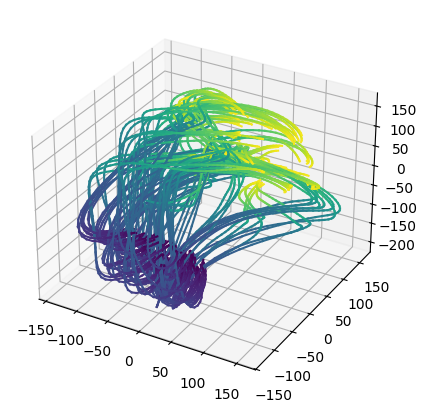

In [3]:
alpha_tilde = np.load("/Users/ariellerosinski/My Drive/Cambridge/Project/SCA_project/outputs/outputs_cluster/a_linear_kernel_5000.npy")

alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde) 
alpha = jnp.dot(P , 1/jnp.sqrt(S))[:,None] * alpha_tilde_QR

alpha_reshaped = alpha.reshape(K,T,d)                                           #(K, T, d)
mean = jnp.mean(alpha_reshaped, axis=(0), keepdims=True)                        #(1, T, d)
optimized_alpha_H = (alpha_reshaped - mean).reshape(K*T,d)                      #(K*T,d)
projection = jnp.einsum('ij,imk->mjk', optimized_alpha_H, K_A_X)                #(K*T,d) @ (K*T, K, T) --> (K, d, T)


plot_3D(projection)